In [22]:
import mplfinance as mpf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import ta
import lightgbm as lgb
from lightgbm import LGBMClassifier

from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix


## Data Gathering and Preprocessing

Financial data is rarely free especially intraday financial futures data. The platform QuantConnect makes data available from different providers as part of their membership, but the data is not allowed out of their platform. Due to this restriction, the data used for data analysis was downloaded from firstratedata.com. The downloaded intraday data ranges from continuous BTC futures data in different time intervals (1 minute, 5 minute, 30 minute, 1 hour, etc.). The focus for this project is 5 minute intraday data for BTC futures. The 5 minute time frame was used for both data analysis and model building. The initial data frame was downloaded as a text file and converted into a csv. 

In [37]:
five_min_data = pd.read_csv("BTC_continuous_adjusted_5min.txt", header = None)
five_min_data.columns = ['time','high','low','open','close','volume']
five_min_data.set_index(['time'], inplace=True, append=True, drop=True)
five_min_data.reset_index(level=0, drop=True, inplace=True)
five_min_data.head()

,high,low,open,close,volume
time,,,,,
2017-12-17 18:00:00,24665.29,24665.29,24295.29,24295.29,40
2017-12-17 18:05:00,24295.29,24295.29,24115.29,24195.29,21
2017-12-17 18:10:00,24190.29,24190.29,23995.29,24040.29,18
2017-12-17 18:15:00,24015.29,24065.29,23530.29,23620.29,19
2017-12-17 18:20:00,23650.29,23695.29,23330.29,23560.29,22


In [38]:
continuous_history = five_min_data.loc['2021-1-1':'2021-12-31']
continuous_history.tail()

,high,low,open,close,volume
time,,,,,
2021-12-30 23:20:00,47525.0,47670.0,47525.0,47585.0,26
2021-12-30 23:25:00,47700.0,47720.0,47610.0,47610.0,7
2021-12-30 23:30:00,47555.0,47555.0,47555.0,47555.0,1
2021-12-30 23:35:00,47600.0,47600.0,47600.0,47600.0,1
2021-12-30 23:45:00,47585.0,47585.0,47575.0,47575.0,2


The data above shows the time as the index and five columnns (high, low, open, close, and volume). The first four columns are essential for OHLC charts, a bar chart that shows the open, high, low and close for prices for each period. In the data above, the OHLC prices are per every 5 minutes. 

For the purpose of analysis, a subset of the data was partitioned from 1-1-2021 till 1-1-2022. Taking a high look at the data, we see that there are 36,078 rows and no missing data or null values to potentially impute.  The data printed shows basic statistical information of the raw data. There is a mass spike in volume at some point in trading, which is worth exploring how that outlier affected the closing price. 

In [39]:
continuous_history.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16320 entries, 2021-10-01 00:00:00 to 2021-12-30 23:45:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   high    16320 non-null  float64
 1   low     16320 non-null  float64
 2   open    16320 non-null  float64
 3   close   16320 non-null  float64
 4   volume  16320 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 765.0+ KB


In [40]:
#Find missing data
missing = continuous_history.isnull()
print(missing.describe())
fframe = continuous_history.copy()

         high    low   open  close volume
count   16320  16320  16320  16320  16320
unique      1      1      1      1      1
top     False  False  False  False  False
freq    16320  16320  16320  16320  16320


In [88]:
fframe.describe()

,high,low,open,close,volume,EMA21,SMA_20,stddev,Upper,Lower,rsi,VWAP,Stoch,MACD,MACDEMA,ATR,OBV,Returns,Up_Down
count,16320.000000,16320.000000,16320.000000,16320.000000,16320.000000,16303.000000,16303.000000,16303.000000,16303.000000,16303.000000,16319.000000,16309.000000,16309.000000,16298.000000,16290.000000,16320.000000,16320.000000,16319.000000,16319.000000
mean,56004.523958,56065.194914,55942.856066,56004.404779,24.506250,56014.272142,56014.321919,200.771184,56415.823682,55612.820157,48.377142,56034.440802,39.758981,1.100190,1.028758,89.248898,268.056495,0.020290,0.007047
std,10319.502569,10330.207271,10308.474256,10319.391839,39.191821,10315.179490,10316.807796,159.642888,10385.190849,10257.914461,30.656247,10321.589243,54.084239,155.181020,146.669269,36.527566,1756.529047,0.140994,1.000006
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.022183,1.000000,-1461.904762,-1257.624338,-1109.890654,0.000000,-3725.000000,-0.083836,-1.000000
25%,49570.000000,49625.000000,49525.000000,49570.000000,5.000000,49564.481487,49563.625000,113.904825,49965.559956,49221.471408,20.194285,49600.351776,0.000000,-71.552677,-68.888689,66.747621,-1249.000000,-0.001234,-1.000000
50%,57880.000000,57942.500000,57825.000000,57882.500000,13.000000,57847.600217,57849.250000,157.525896,58307.357414,57449.080654,47.816726,57895.018939,35.294118,1.000000,1.000000,83.299773,439.500000,0.000078,1.000000
75%,62620.000000,62681.250000,62541.250000,62620.000000,29.000000,62640.564936,62604.250000,231.803569,63129.626540,62141.786812,76.376373,62662.477965,79.532164,67.427800,64.173320,104.537696,1612.000000,0.001291,1.000000
max,69755.000000,69995.000000,69655.000000,69735.000000,894.000000,69548.087211,69578.500000,2304.154643,70378.094908,69446.706701,100.000000,69654.011580,1495.454545,895.696786,843.150105,461.762202,4913.000000,1.000000,1.000000


## Feature Engineering

### Technical Indicators

The data provides only numerical data and while it is possible to create lagged features using only price data, for the purpose of this project, technical indicators will be calculated. Technical indicators as defined by [Investopedia] "are heuristic or pattern-based signals produced by the price, volume and/or open interest of a security or contract used by traders who follow technical analysis". The general idea is to use historical data as a way to determine future price movements. The indicators used for this project are two moving averages (Exponential Moving Average, Simple Moving Average), Bollinger Bands, Relative Strength Index (RSI), Stochastic Oscillator, Moving Average Convergence Divergence (MACD), On Balance Volume, Average True Range (ATR), and Volume-Weighted Average Price (VWAP). 

[Investopedia]: https://www.investopedia.com/terms/t/technicalindicator.asp "Investopedia"

#### EMA and SMA

The exponential moving average and simple moving average are moving averages that are calculated differently. The simple moving average for a 20 day period would calculate the value by adding closing prices over a 20 day period and dividing by 20. The exponential moving average is meant to react faster to recent price movements. The EMA is calculated as follow:
> $EMA = ((Price(current) - previous EMA) x multiplier) + previous EMA$

> Multiplier = $\frac{2}{1 + N}\$

N is the number of chosen days (20 was used for indicator calculation)



#### Bollinger Bands

Bollinger Bands measure volatility by placing bands above and below a moving average (the default value is a 20 period simple moving average). The outer bands are set 2 standard deviations above and below the middle band. 

> **Formulas:**
>>  Middle Band = 20 day simple moving average

>>  Upper Band = 20 SMA + (20SMA std x 2)

>>  Lower Band = 20 SMA - (20SMA std x 2)


#### Relative Strength Index (RSI)

RSI is primarily a momentum indicator that is used to determine if the financial security being traded is overbought or oversold. A stock or futures contract is overbought when there is unjustifiable demand pushing the prices upward, meaning a move towards the downturn is expected in the near future to "correct" the price/value imbalance. The opposite is true when the security traded is considered oversold. Traders generally look for the moment to buy an oversold stock/future/currency as the price is expected to move upwards again. The RSI ranges from 0 to 100, when the RSI is above 70 the security is considered overbought and when the the RSI is below 30, the security is oversold. 

> **Formulas:**
>> $RSI=100-\frac{100}{RS}\$

>> $RS=\frac{Average Gain Over 14 days}{Average Loss Over 14 days}\$

The RS value can be adjusted, but the default value of 14 was used for calculating the technical indicator. 


#### Stochastic Oscillator 

The stochastic oscillator is another momentum indicator helping traders decide if the security is overbought or oversold. The indicator uses two indicators %K (the fast indicator) and %D the slow indicator which is a 3 period moving average of %K. These values were not altered to calculate the stochastic oscillator. 

> **Formula for %K:**
>> $(\frac{C - L14}{H14-L14})x100\$
- C = recent closing price
- L14 = the low of the previous 14 trading sessions
- H14 = the high of the previous 14 trading sessions
- %K = current value of the stochastic indicator

#### Moving Average Convergence Divergence (MACD)

The MACD is another momentum/trend indicator. It shows the relationship between two moving averages. The MACD is the difference between the 12 EMA and 26 EMA. The signal line is the 9 EMA. Typically, when the MACD goes below the 9 EMA, it is a sign to sell and when the MACD goes above the 9 EMA, it is a sign to buy. There are different strategies that change the default values, however, just like the previous indicators only default values were used. 


#### On Balance Volume

On Balance Volume (OBV) relates price and volume. 

#### Average True Range (ATR)

ATR measures market volatility. It is usually derived from the 14 day simple moving average of a series range indicators. 

#### Volume-Weighted Average Price

VWAP is considered a trading benchmark used by traders to determine the average traded price for a particular security. VWAP is determined by both volume and price. 

$VWAP = \frac{\Sigma Price * Volume}{\Sigma Volume}$

In [28]:
#Add different indicators to the dataframe using a mix of 'manual' math and utilizing the ta library (technical analysis)
def applyindicators(df):
    df['EMA21'] = ta.trend.ema_indicator(df.close,21)
    df['SMA_20'] = df.close.rolling(20).mean()
    df['stddev'] = df.close.rolling(20).std()
    df['Upper'] = df.SMA_20 + df.stddev * 2 #Calculate top band
    df['Lower'] = df.SMA_20 - df.stddev * 2 #Calculate lower band
    df['rsi'] = ta.momentum.rsi(df.close, 2)
    df['VWAP'] = ta.volume.volume_weighted_average_price(df.high,df.low,df.close,df.volume)
    df['Stoch'] = ta.momentum.stoch(df.high, df.low, df.close, 14, 3)
    df['MACD'] =  ta.trend.macd(df.close,26,12)
    df['MACDEMA'] = ta.trend.macd_signal(df.close, 26, 12, 9)
    df['ATR'] = ta.volatility.average_true_range(df.high, df.low, df.close, 14)
    df['OBV'] = ta.volume.on_balance_volume(df.close, df.volume)

In [43]:
applyindicators(fframe)

### Target Variable

The aim of our model is to create a classifier that indicates whether the security's closing price (BTC Futures) is going to move either up or down within five minutes. In order to create that feature, a "Returns" column needs to be created that calculates the percent difference between initial closing price and the closing price after. The pct_change function with a 1 period lag was utilized to calculate the "Returns" column. The next step was to create a "Up_Down" column. By running the "np.sign" function on the "Returns" column, all positive percent returns are assigned a 1 and all negative returns given a -1. This creates a binary classification. There were instances of zero price changes but those were assigned a 1. 

In [51]:
fframe["Returns"] = fframe.close.pct_change(periods=1)
fframe["Up_Down"] = np.sign(fframe["Returns"])
fframe.loc[fframe['Up_Down'] == 0.0] = 1.0

## Visualizations

The visualizations below illustrate the volatile nature of Bitcoin Futures and Bitcoin in general. There was an attempt to examine whether volume was positively or negatively correlated with closing prices or returns and there seems to be no relationship between those variables. Looking at the correlation plot, there is a noticeable correlation between Stochastic Oscillator, RSI and returns. 

The technical indicator Bollinger Bands does show some promise of building a strategy solely around mean reversion while VWAP and the moving averages merely demonstrate the overall trend of price movement. 

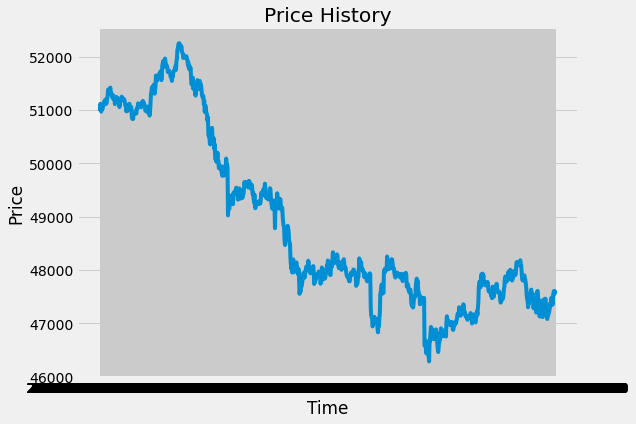

In [44]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8,6))
plt.title( 'Price History')
plt.xlabel("Time")
plt.ylabel("Price")
plt.plot(fframe.tail(1000)['close'])

<AxesSubplot:xlabel='close', ylabel='volume'>

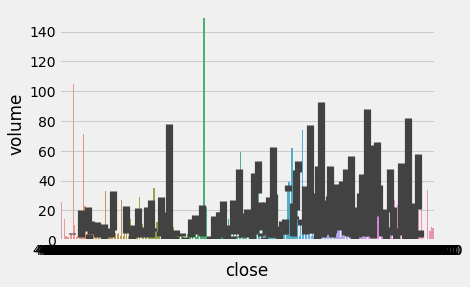

In [53]:
sns.barplot(data=fframe.tail(500), x="close", y="volume")

<AxesSubplot:xlabel='Returns', ylabel='volume'>

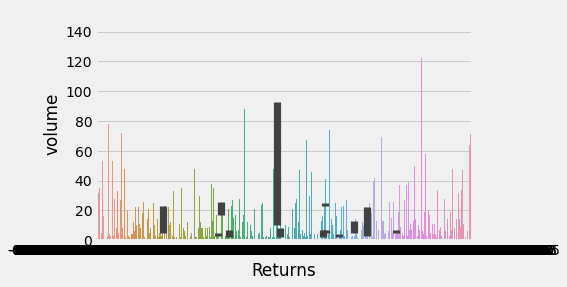

In [52]:
sns.barplot(data=fframe.tail(500), x="Returns", y="volume")

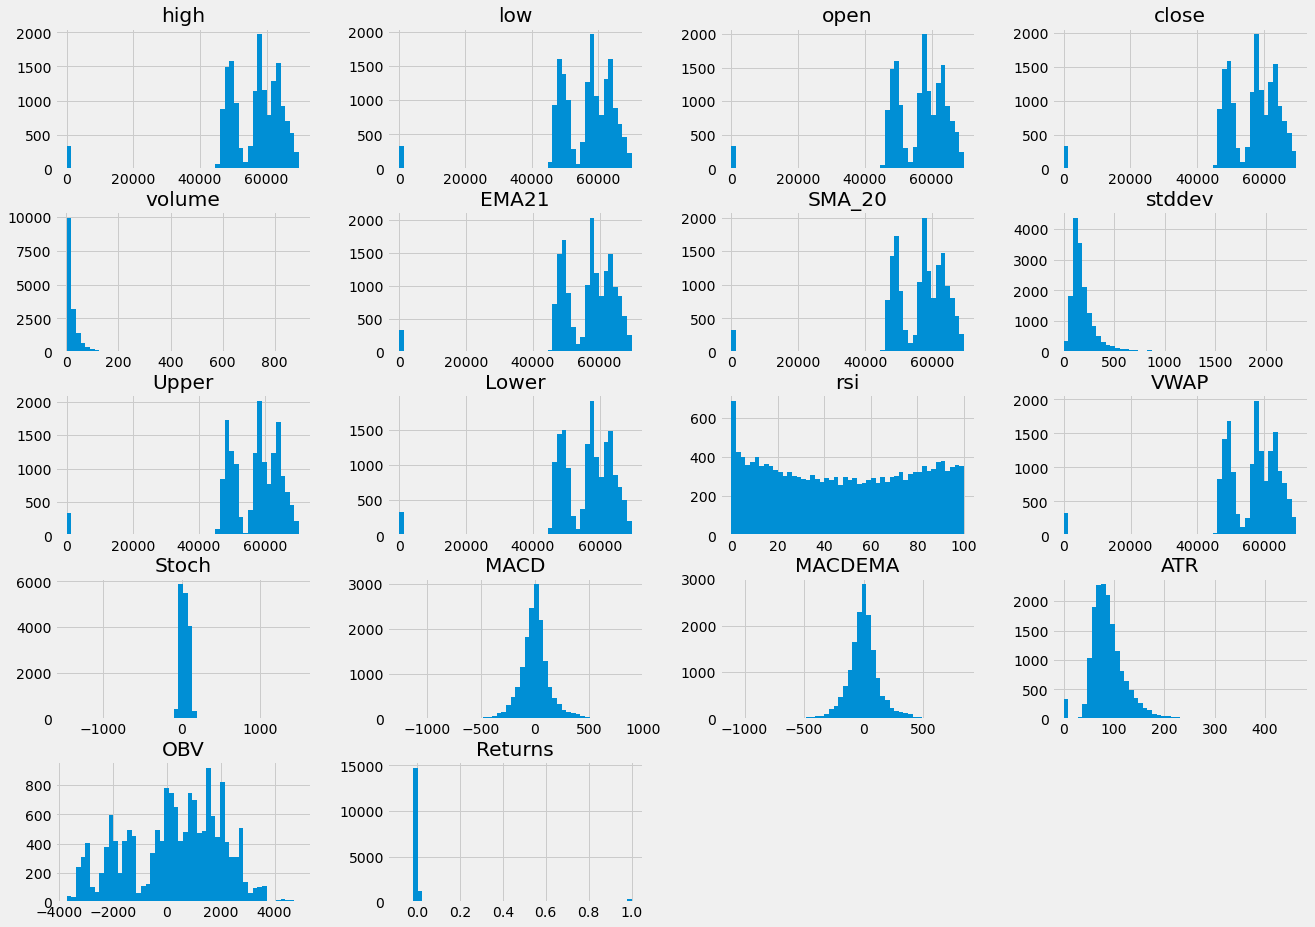

In [32]:
viz_frame = fframe.drop(columns='Up_Down').copy()
viz_frame.hist(bins=50, figsize=(20,15))
plt.show()

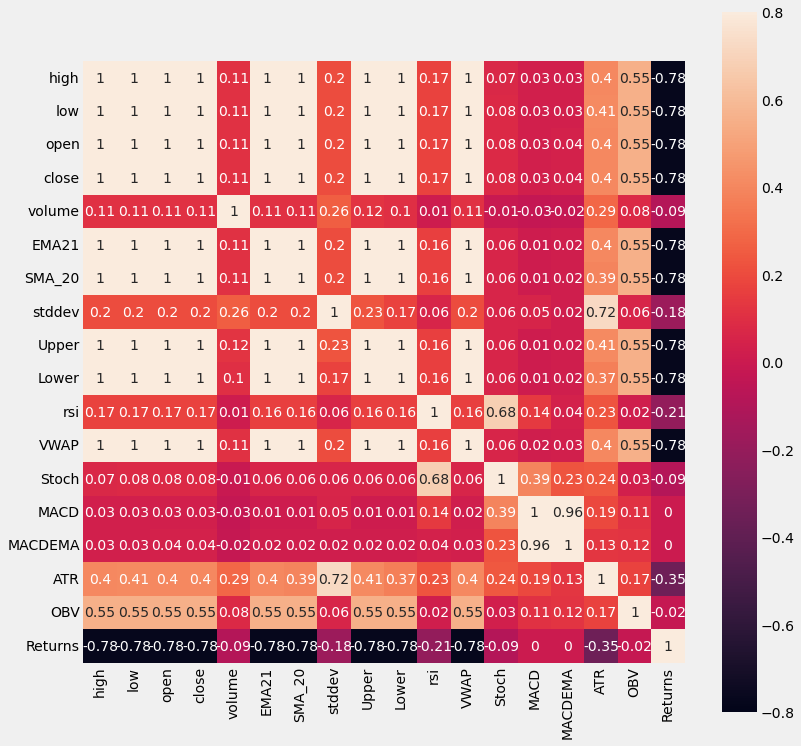

In [87]:
df_corr = fframe.drop(columns=['Up_Down']).corr().round(2)
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(df_corr, vmin=-.8, vmax=.8, square=1, annot=True)

Text(0, 0.5, 'Price')

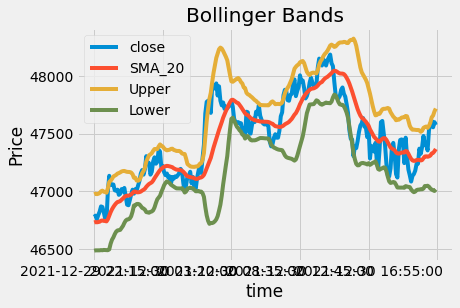

In [48]:
BBPlot = fframe.tail(250)[['close', 'SMA_20', 'Upper', 'Lower']].plot()
BBPlot.set_title("Bollinger Bands")
BBPlot.set_ylabel("Price")

Text(0, 0.5, 'Price')

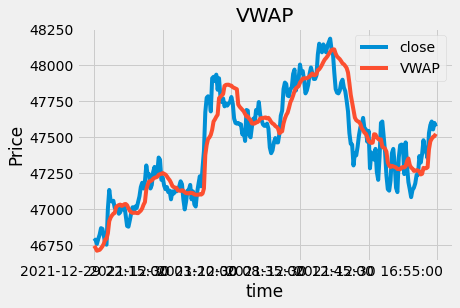

In [49]:
VWAPlot = fframe.tail(250)[['close', 'VWAP']].plot()
VWAPlot.set_title("VWAP")
VWAPlot.set_ylabel("Price")

Text(0, 0.5, 'Price')

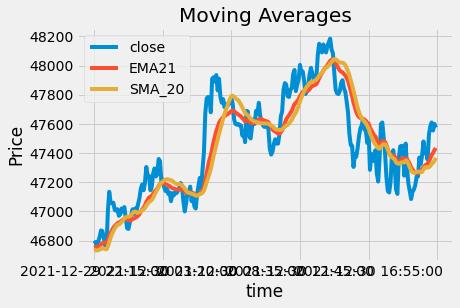

In [50]:
SEMAPlot = fframe.tail(250)[['close','EMA21','SMA_20']].plot()
SEMAPlot.set_title("Moving Averages")
SEMAPlot.set_ylabel("Price")

## Build the Model

### Random Forest

Random Forest is categorized as a supervised learning algorithm and an ensemble of decisions trees trained using the bagging method. Bagging is a combination of several models, producing a final model with a greater degree of accuracy. Random Forests can be utilized for both regression and classification problems. For classifications, the output of the random forest is the class selected by the most trees. Random Forest as a classifier is very efficient and accurate, capable of handling thousands of input variables, handles missing data, and is able to produce feature importance. Since our goal for this project is to a) classify and b) find a relatively accurate algorithm that is fast and capable of handling large amounts of data, Random Forest is a logical first step in our model building process. 

We used the'RandomForestClassifier' function from the sklearn package to build an initial model with fairly impressive results. The model had an accuracy of 85.5%, precision of 86.5%, recall of 85.5% and specificity of 85.4%. Using the feature importance functionality of the algorithm, we can see the most important variables in making predictions. The indicators 'RSI' and 'Stoch' which were postively correlated with returns, make the greatest impact for predictions. A few of the variables are very low impact and can be removed when building the second model. 

In [55]:
#The random forest classifier would not run with the NA values 
fframe2 = fframe.dropna().copy()

In [56]:
#Define our x and y columns 
YCol = fframe2['Up_Down'].copy()
XCols = fframe2.drop(columns=['Up_Down', 'Returns'])

#Split X and y into training and testing set
X_train, X_test, y_train, y_test = train_test_split(XCols, YCol, random_state=0)

#Create a Random Forest Classifier 
rfc = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = 'gini', random_state=0)

#Fit the data into the model
rfc.fit(X_train, y_train)

#Predictions!
y_pred = rfc.predict(X_test)
y_proba = rfc.predict_proba(X_test)

In [ ]:
#Print Accuracy Score
print('Correct Prediction (%):', accuracy_score(y_test, rfc.predict(X_test), normalize=True) * 100)

Accuracy: 0.8551436287748588
Precision: 0.8653022370299858
Recall: 0.8555294117647059
Specificity: 0.8547227926078029


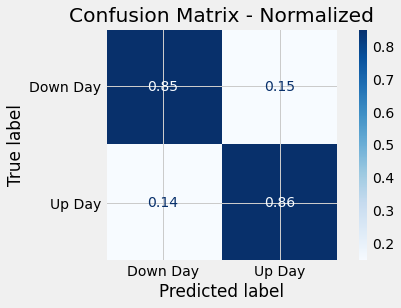

In [57]:
rfmatrix = confusion_matrix(y_test, y_pred)

tru_neg = rfmatrix[0][0]
false_neg = rfmatrix[1][0]
tru_pos = rfmatrix[1][1]
false_pos = rfmatrix[0][1]

accuracy = (tru_neg+ tru_pos) / (tru_neg + tru_pos + false_neg + false_pos)
precision = tru_pos / (tru_pos + false_pos)
recall = tru_pos / (tru_pos + false_neg)
specificity = tru_neg / (tru_neg + false_pos)

print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

disp = plot_confusion_matrix(rfc, X_test, y_test, display_labels = ['Down Day', 'Up Day'], normalize = 'true', cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix - Normalized')
plt.show()


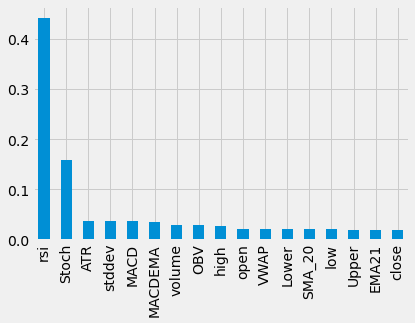

In [58]:
feature_importance = pd.Series(rfc.feature_importances_, index=XCols.columns).sort_values(ascending=False)
fig = feature_importance.plot.bar()

### LightGBM Model

LightGBM (Light Gradient Boosting Machine) is a gradient boosting framework that uses tree based learning algorithms (decision trees) to increase accuracy and speed. Gradient boosting is a method of improving machine learning algorithms by changing weak learners into stronger learners. A weak learner is identified because its output is slightly better than random chance. Gradient Boosting involves making use of a loss function (to identify weak learners), weak learners (decision trees) and an additive model (used to minimize the loss when adding new trees). LightGBM is faster than other gradient boosting machines, such as XGBoost, because it grows leaf-wise not level-wise like other algorithms. Due to the fast and "light" nature of LightGBM, it makes use of less memory and is still able to handle large volumes of data. Given the computational limitations that a retail trader has or might encounter, LightGBM is ideal for building our second model. 

The LightGBM model produced slightly better results than the generic RandomForestClassifier model. The training accuracy was 90.36% and the testing accuracy was 86.30%. The top important features did not change, "RSI" and "Stoch" are still the top two but the indicators are almost equal in importance as opposed to the initial model.  

In [59]:
#Drop features that hold little importance based on the previous model and high correlation levels
fframe3 = fframe2.copy()
fframe3 = fframe3.drop(columns=['high','close','open','low', 'EMA21'])

In [ ]:
#Define our x and y columns 
YCol2 = fframe3['Up_Down'].copy()
XCols2 = fframe3.drop(columns=['Up_Down', 'Returns'])

#Split X and y into training and testing set
X_train, X_test, y_train, y_test = train_test_split(XCols2, YCol2, random_state=0)

LightModel = lgb.LGBMClassifier(learning_rate=0.09, max_depth=-5,random_state=42)
LightModel.fit(X_train, y_train,eval_set=[(X_test,y_test),(X_train, y_train)],
              verbose=20,eval_metric='logloss')

In [ ]:
print('Training accuracy {:.4f}'.format(LightModel.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(LightModel.score(X_test,y_test)))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

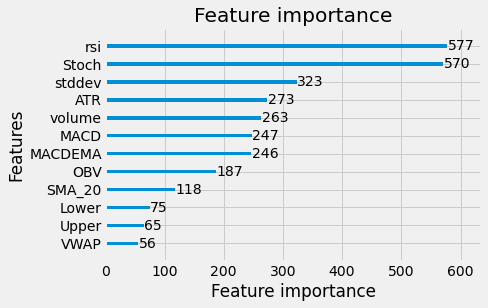

In [62]:
lgb.plot_importance(LightModel)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

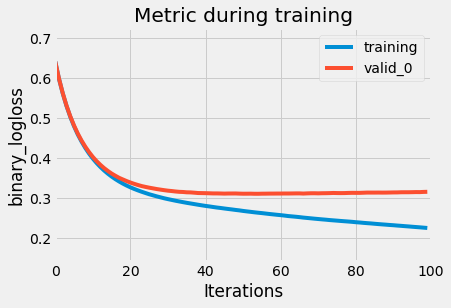

In [63]:
lgb.plot_metric(LightModel)

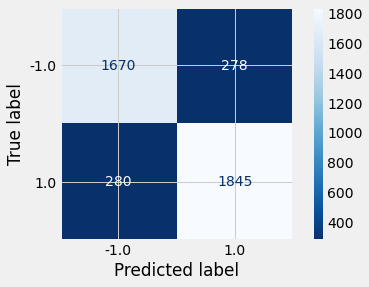

In [64]:
metrics.plot_confusion_matrix(LightModel, X_test, y_test, cmap='Blues_r')

<AxesSubplot:>

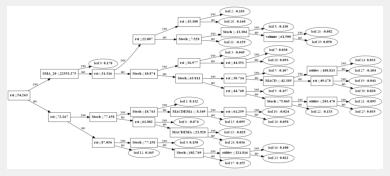

In [91]:
lgb.plot_tree(LightModel)

#### RandomSearch Optimization

In an effort to tune the LightGBM hyperparameters, RandomSearchCV is used as it is faster than GridSearchCV. Defining the grid parameters, we find that the "optimal" parameters are:
 - reg_alpha : 0.1
 - num_leaves: 20
 - min_child_samples: 5
 - max_depth: 10
 - learning_rate: 0.05
 
The tuned hyperparamters produced a model with an accuracy score of 86.5% barely better than our manually selected parameters.

In [29]:
#Define grid parameters
parameters = {'num_leaves':[20,40,60,80,100],
              'min_child_samples':[5,10,15],
              'max_depth':[-1,5,10,20],
              'learning_rate':[0.05,0.1,0.2],
              'reg_alpha':[0,0.1,0.03]}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
lgb1=lgb.LGBMClassifier()
LightRandom=RandomizedSearchCV(lgb1,parameters,scoring='accuracy',n_iter=100)
LightRandom.fit(X=X_train, y=y_train)
print(LightRandom.best_params_)
predicted=LightRandom.predict(X_test)
print(accuracy_score(y_test, predicted))


## Results

## Conclusion

https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/
https://neptune.ai/blog/xgboost-vs-lightgbm
https://www.geeksforgeeks.org/lightgbm-light-gradient-boosting-machine/
https://datascience.stackexchange.com/questions/77352/generate-pdf-from-jupyter-notebook-without-code